# Imports

In [1]:
import xpress as xp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyreadr import read_r
from scipy.interpolate import interp1d
from param_watervalues import Reservoir
from time import time
from random import randint, seed

In [2]:
%load_ext line_profiler

In [3]:
%matplotlib widget

In [4]:
xp.controls.outputlog = 0
xp.controls.threads = 1
xp.controls.scaling = 0
xp.controls.presolve = 0
xp.controls.feastol = 1.e-7
xp.controls.optimalitytol = 1.e-7
xp.setOutputEnabled(False)

# Données d'entrées

In [5]:
study_path = "D:/Users/gerbauxjul/Documents/6-Etudes Antares/ERAA_scandinavie"
output_path = study_path+"/user/fast_fi00"
# study_path = "D:/Users/gerbauxjul/Documents/6-Etudes Antares/OneNodeBase"
# output_path = study_path+"/user"

In [6]:
S = 52
NTrain = 10
H = 168

# Fonctions

## Fonctions secondaires

In [7]:
def retrieve_problem(year,week,output_path,itr=1):
    model = xp.problem()
    # f = open(output_path+f"/logs_xpress/read.log", "a")
    # model.setlogfile(output_path+f"/logs_xpress/read.log")
    model.controls.xslp_log = -1
    model.controls.lplogstyle = 0
    model.read(output_path+f"/problem-{year}-{week}--optim-nb-{itr}.mps")
    return(model)

In [8]:
def create_weekly_problem_itr(k,s,output_path, reservoir, pen_low, pen_high,pen_final):
    model = retrieve_problem(k+1,s+1,output_path)
    

    cst = model.getConstraint()
    binding_id = [i for i in range(len(cst)) if "WeeklyWaterAmount" in cst[i].name]

    x_s = xp.var("x_s",lb = 0, ub = reservoir.capacity)
    model.addVariable (x_s)          # State at the begining of the current week

    x_s_1 = xp.var("x_s_1",lb = 0, ub = reservoir.capacity)
    model.addVariable (x_s_1) # State at the begining of the following week

    U = xp.var("u",lb = -reservoir.P_pump[7*s]*reservoir.efficiency*H, ub = reservoir.P_turb[7*s]*H)
    model.addVariable (U) # State at the begining of the following week

    model.addConstraint(x_s_1 <= x_s - U + reservoir.inflow[s,k]*H)

    y = xp.var("y")

    model.addVariable (y)    # Penality for violating guide curves

    if s!=S-1:
        model.addConstraint(y >=  -pen_low* (x_s_1 - reservoir.Xmin[s]))
        model.addConstraint(y >=  pen_high* (x_s_1 - reservoir.Xmax[s]))
    else :
        model.addConstraint(y >=  -pen_final* (x_s_1 - reservoir.Xmin[s]))
        model.addConstraint(y >=  pen_final* (x_s_1 - reservoir.Xmax[s]))

    z = xp.var("z",lb = float('-inf'), ub =  float('inf'))

    model.addVariable (z) # Auxiliar variable to introduce the piecewise representation of the future cost

    return([model,binding_id,U,x_s,x_s_1, z, y]) #, model_copy,x_s,x_s_1, z, y])
    

In [9]:
def modify_weekly_problem_itr(model,binding_id,u):

    model.chgrhs(binding_id,[u])

    model.lpoptimize()

    if model.attributes.lpstatus==1:
        beta = model.getObjVal()
        lamb = model.getDual(binding_id)[0]
        return(beta,lamb,model.attributes.SIMPLEXITER, model.attributes.TIME)
    else :
        raise(ValueError)

In [10]:
def calculate_VU(reward, reservoir,X,U, pen_low, pen_high, pen_final):
    V = np.zeros((len(X), S+1, NTrain))

    for s in range(S-1,-1,-1):#
        
        if s==S-1:
            pen = interp1d([0,reservoir.Xmin[s],reservoir.Xmax[s],reservoir.capacity],[-pen_final*(reservoir.Xmin[s]),0,0,-pen_final*(reservoir.capacity-reservoir.Xmax[s])])
        else :
            pen = interp1d([0,reservoir.Xmin[s],reservoir.Xmax[s],reservoir.capacity],[-pen_low*(reservoir.Xmin[s]),0,0,-pen_high*(reservoir.capacity-reservoir.Xmax[s])])

        for k in range(NTrain):
            V_fut = interp1d(X, V[:, s+1,k])
            Gs = lambda x: min([reward[s][k][i][0]*x+reward[s][k][i][1] for i in range(len(reward[s][k]))])
            for i in range(len(X)):
                xf = 0
                Vu = float('-inf')

                for i_fut in range(len(X)):
                    u = -X[i_fut] + X[i] + reservoir.inflow[s,k]*H
                    if -reservoir.P_pump[7*s]*H <= u <= reservoir.P_turb[7*s]*H:
                        G = Gs(u)
                        penalty = pen(X[i_fut])
                        if (G + V[i_fut, s+1,k]+penalty) > Vu:
                            Vu = G + V[i_fut, s+1,k]+penalty
                            xf = X[i_fut]
                
                for u in range(len(U[s][k])):
                    state_fut = min(reservoir.capacity,X[i] - U[s][k][u] + reservoir.inflow[s,k]*H) 
                    if 0 <= state_fut :
                        penalty = pen(state_fut)
                        G = Gs(U[s][k][u])
                        if (G + V_fut(state_fut)+penalty) > Vu:
                            Vu = (G + V_fut(state_fut)+penalty)
                            xf = state_fut

                Umin = X[i]+ reservoir.inflow[s,k]*H-reservoir.Xmin[s]
                if -reservoir.P_pump[7*s]*H <= Umin <= reservoir.P_turb[7*s]*H:
                    state_fut = X[i] - Umin + reservoir.inflow[s,k]*H
                    penalty = pen(state_fut)
                    if (Gs(Umin) + V_fut(state_fut)+penalty) > Vu:
                        Vu = Gs(Umin) + V_fut(state_fut)+penalty
                        xf = state_fut

                Umax = X[i]+ reservoir.inflow[s,k]*H-reservoir.Xmax[s]
                if -reservoir.P_pump[7*s]*H <= Umax <= reservoir.P_turb[7*s]*H:
                    state_fut = X[i] - Umax + reservoir.inflow[s,k]*H 
                    penalty = pen(state_fut)
                    if (Gs(Umax) + V_fut(state_fut)+penalty) > Vu:
                        Vu = Gs(Umax) + V_fut(state_fut)+penalty
                        xf = state_fut
            
                V[i, s, k] = Vu + V[i,s,k]

        V[:,s,:] = np.repeat(np.mean(V[:,s,:],axis=1,keepdims=True),NTrain,axis=1)
    return np.mean(V,axis=2)

In [11]:
def compute_x(reservoir,X,U,V,reward,pen_low,pen_high, pen_final, itr, k=None):
    initial_x = [reservoir.initial_level]
    if k == None:
        controls = np.zeros((S,NTrain))
    else :
        controls = np.zeros(S)
    cout = 0
    seed(19*itr)
    
    for s in range(S):
        cout_s =0
        V_fut = interp1d(X, V[:, s+1])
        if k == None :
            k_s = randint(0,NTrain-1)
        else :
            k_s = k
        
        if s==S-1:
            pen = interp1d([0,reservoir.Xmin[s],reservoir.Xmax[s],reservoir.capacity],[-pen_final*(reservoir.Xmin[s]),0,0,-pen_final*(reservoir.capacity-reservoir.Xmax[s])])
        else :
            pen = interp1d([0,reservoir.Xmin[s],reservoir.Xmax[s],reservoir.capacity],[-pen_low*(reservoir.Xmin[s]),0,0,-pen_high*(reservoir.capacity-reservoir.Xmax[s])])
        Gs = lambda x: min([reward[s][k_s][i][0]*x+reward[s][k_s][i][1] for i in range(len(reward[s][k_s]))])

        Vu = float('-inf')

        for i_fut in range(len(X)):
            u = -X[i_fut] + initial_x[-1] + reservoir.inflow[s,k_s]*H
            if -reservoir.P_pump[7*s]*H <= u <= reservoir.P_turb[7*s]*H:
                G = Gs(u)
                penalty = pen(X[i_fut])
                if (G + V[i_fut, s+1]+penalty) > Vu:
                    Vu = G + V[i_fut, s+1]+penalty
                    xf = X[i_fut]
                    cout_s = G

        for u in range(len(U[s][k_s])):
            state_fut = min(reservoir.capacity,initial_x[-1] - U[s][k_s][u] + reservoir.inflow[s,k_s]*H) 
            if 0 <= state_fut :
                penalty = pen(state_fut)
                G = Gs(U[s][k_s][u])
                if (G + V_fut(state_fut)+penalty) > Vu:
                    Vu = (G + V_fut(state_fut)+penalty)
                    xf = state_fut
                    cout_s =G

        Umin = initial_x[-1]+ reservoir.inflow[s,k_s]*H-reservoir.Xmin[s]
        if -reservoir.P_pump[7*s]*H <= Umin <= reservoir.P_turb[7*s]*H:
            state_fut = initial_x[-1] - Umin + reservoir.inflow[s,k_s]*H
            penalty = pen(state_fut)
            if (Gs(Umin) + V_fut(state_fut)+penalty) > Vu:
                Vu = Gs(Umin) + V_fut(state_fut)+penalty
                xf = state_fut
                cout_s = Gs(Umin)

        Umax = initial_x[-1]+ reservoir.inflow[s,k_s]*H-reservoir.Xmax[s]
        if -reservoir.P_pump[7*s]*H <= Umax <= reservoir.P_turb[7*s]*H:
            state_fut = initial_x[-1] - Umax + reservoir.inflow[s,k_s]*H 
            penalty = pen(state_fut)
            if (Gs(Umax) + V_fut(state_fut)+penalty) > Vu:
                Vu = Gs(Umax) + V_fut(state_fut)+penalty
                xf = state_fut
                cout_s = Gs(Umax)

        initial_x.append(xf)
        controls[s] = min(-(initial_x[s+1]-initial_x[s]-reservoir.inflow[s,k_s]*H), reservoir.P_turb[7*s]*H)
        cout += cout_s
    return(initial_x, controls, cout)

In [26]:
def compute_x_multi_scenario(reservoir,X,U,V,reward,pen_low,pen_high, pen_final, itr):
    initial_x = np.zeros((S+1,NTrain))
    initial_x[0] = reservoir.initial_level
    cout = 0
    np.random.seed(19*itr)
    controls = np.zeros((S,NTrain))
    
    for s in range(S):
        
        V_fut = interp1d(X, V[:, s+1])
        for j,k_s in enumerate(range(NTrain)):#enumerate(np.random.permutation(range(NTrain))):
            cout_s =0
        
            if s==S-1:
                pen = interp1d([0,reservoir.Xmin[s],reservoir.Xmax[s],reservoir.capacity],[-pen_final*(reservoir.Xmin[s]),0,0,-pen_final*(reservoir.capacity-reservoir.Xmax[s])])
            else :
                pen = interp1d([0,reservoir.Xmin[s],reservoir.Xmax[s],reservoir.capacity],[-pen_low*(reservoir.Xmin[s]),0,0,-pen_high*(reservoir.capacity-reservoir.Xmax[s])])
            Gs = lambda x: min([reward[s][k_s][i][0]*x+reward[s][k_s][i][1] for i in range(len(reward[s][k_s]))])

            Vu = float('-inf')

            for i_fut in range(len(X)):
                u = -X[i_fut] + initial_x[s,j] + reservoir.inflow[s,k_s]*H
                if -reservoir.P_pump[7*s]*H <= u <= reservoir.P_turb[7*s]*H:
                    G = Gs(u)
                    penalty = pen(X[i_fut])
                    if (G + V[i_fut, s+1]+penalty) > Vu:
                        Vu = G + V[i_fut, s+1]+penalty
                        xf = X[i_fut]
                        cout_s = G

            for u in range(len(U[s][k_s])):
                state_fut = min(reservoir.capacity,initial_x[s,j] - U[s][k_s][u] + reservoir.inflow[s,k_s]*H) 
                if 0 <= state_fut :
                    penalty = pen(state_fut)
                    G = Gs(U[s][k_s][u])
                    if (G + V_fut(state_fut)+penalty) > Vu:
                        Vu = (G + V_fut(state_fut)+penalty)
                        xf = state_fut
                        cout_s =G

            Umin = initial_x[s,j]+ reservoir.inflow[s,k_s]*H-reservoir.Xmin[s]
            if -reservoir.P_pump[7*s]*H <= Umin <= reservoir.P_turb[7*s]*H:
                state_fut = initial_x[s,j] - Umin + reservoir.inflow[s,k_s]*H
                penalty = pen(state_fut)
                if (Gs(Umin) + V_fut(state_fut)+penalty) > Vu:
                    Vu = Gs(Umin) + V_fut(state_fut)+penalty
                    xf = state_fut
                    cout_s = Gs(Umin)

            Umax = initial_x[s,j]+ reservoir.inflow[s,k_s]*H-reservoir.Xmax[s]
            if -reservoir.P_pump[7*s]*H <= Umax <= reservoir.P_turb[7*s]*H:
                state_fut = initial_x[s,j] - Umax + reservoir.inflow[s,k_s]*H 
                penalty = pen(state_fut)
                if (Gs(Umax) + V_fut(state_fut)+penalty) > Vu:
                    Vu = Gs(Umax) + V_fut(state_fut)+penalty
                    xf = state_fut
                    cout_s = Gs(Umax)

            initial_x[s+1,j] = xf
            controls[s,k_s] = min(-(initial_x[s+1,j]-initial_x[s,j]-reservoir.inflow[s,k_s]*H), reservoir.P_turb[7*s]*H)
            if controls[s,k_s]<-1e-7:
                print(s,j,k_s, initial_x[:,j],Vu)
            cout += cout_s
    return(initial_x, controls, cout/NTrain)

In [13]:
def find_likely_control(reservoir,X,U,V,reward,pen_low,pen_high, pen_final, level_i, s, k):
    
    V_fut = interp1d(X, V[:, s+1])
        
        
    if s==S-1:
        pen = interp1d([0,reservoir.Xmin[s],reservoir.Xmax[s],reservoir.capacity],[-pen_final*(reservoir.Xmin[s]),0,0,-pen_final*(reservoir.capacity-reservoir.Xmax[s])])
    else :
        pen = interp1d([0,reservoir.Xmin[s],reservoir.Xmax[s],reservoir.capacity],[-pen_low*(reservoir.Xmin[s]),0,0,-pen_high*(reservoir.capacity-reservoir.Xmax[s])])
    Gs = lambda x: min([reward[s][k][i][0]*x+reward[s][k][i][1] for i in range(len(reward[s][k]))])

    Vu = float('-inf')

    for i_fut in range(len(X)):
        u = -X[i_fut] + level_i + reservoir.inflow[s,k]*H
        if -reservoir.P_pump[7*s]*H <= u <= reservoir.P_turb[7*s]*H:
            G = Gs(u)
            penalty = pen(X[i_fut])
            if (G + V[i_fut, s+1]+penalty) > Vu:
                Vu = G + V[i_fut, s+1]+penalty
                control = u

    for u in range(len(U[s][k])):
        state_fut = min(reservoir.capacity,level_i - U[s][k][u] + reservoir.inflow[s,k]*H) 
        if 0 <= state_fut :
            penalty = pen(state_fut)
            G = Gs(U[s][k][u])
            if (G + V_fut(state_fut)+penalty) > Vu:
                Vu = (G + V_fut(state_fut)+penalty)
                control = U[s][k][u]

    Umin = level_i+ reservoir.inflow[s,k]*H-reservoir.Xmin[s]
    if -reservoir.P_pump[7*s]*H <= Umin <= reservoir.P_turb[7*s]*H:
        state_fut = level_i - Umin + reservoir.inflow[s,k]*H
        penalty = pen(state_fut)
        if (Gs(Umin) + V_fut(state_fut)+penalty) > Vu:
            Vu = Gs(Umin) + V_fut(state_fut)+penalty
            control = Umin

    Umax = level_i+ reservoir.inflow[s,k]*H-reservoir.Xmax[s]
    if -reservoir.P_pump[7*s]*H <= Umax <= reservoir.P_turb[7*s]*H:
        state_fut = level_i - Umax + reservoir.inflow[s,k]*H 
        penalty = pen(state_fut)
        if (Gs(Umax) + V_fut(state_fut)+penalty) > Vu:
            Vu = Gs(Umax) + V_fut(state_fut)+penalty
            control = Umax

    return(control)

In [14]:
def compute_upper_bound(reservoir,list_models,X,V, hot_start):
    cout = 0
    controls = np.zeros((S,NTrain))
    for k in range(NTrain):

        rstatus = []
        cstatus = []
        
        level_i = reservoir.initial_level
        for s in range(S):
            print(f"{k} {s}",end="\r")
            m = list_models[s][k]
            # Future cost: piecewise representation of the future cost
            nb_cons = m[2].attributes.rows
          

            for i in range(len(X)-1):
                if (V[i+1, s+1]<float('inf'))&(V[i, s+1]<float('inf')):
                    m[2].addConstraint(m[5] >= (V[i+1, s+1] - V[i, s+1]) / (X[i+1] - X[i]) * (m[4] - X[i]) + V[i, s+1])

            cst_initial_level = m[3] == level_i
            m[2].addConstraint(cst_initial_level)

            if (len(rstatus)!=0)&(hot_start):
                m[2].loadbasis(rstatus, cstatus)

            m[2].lpoptimize()

            if m[2].attributes.lpstatus==1:
                if hot_start:
                    m[2].getbasis(rstatus, cstatus)
                beta = m[2].getObjVal()
                xf = m[2].getSolution(m[4])
                z = m[2].getSolution(m[5])
                y = m[2].getSolution(m[6])
                m[2].delConstraint(range(nb_cons,m[2].attributes.rows))
                cout += beta
                controls[s,k]=-(xf-level_i-reservoir.inflow[s,k]*H)
                level_i = xf
                if s!=S-1:
                    cout += - z - y
                
            else :
                raise(ValueError)
    return(cout/NTrain, controls)
            

In [15]:
def update_reward_approximation(reward,points,lamb,beta,new_control):

    Gs = lambda x: min([reward[i][0]*x+reward[i][1] for i in range(len(reward))])
    new_cut = lambda x:-lamb*x -beta + lamb*new_control
    new_reward = []
    new_points = [points[0]]

    if (len(points)!=len(reward)+1) :
        print(reward)
        print(points)
        raise(ValueError)
    
    for i in range(len(points)):
        if i==0:
            if (new_cut(points[i]) < Gs(points[i])) :
                new_reward.append((-lamb,-beta + lamb*new_control))
                if (new_cut(points[i+1]) >= Gs(points[i+1])) :
                    if -lamb-reward[i][0]!=0:
                        new_points.append(-(-beta + lamb*new_control-reward[i][1])/(-lamb-reward[i][0]))
                        new_reward.append(reward[i])
            elif (new_cut(points[i]) >= Gs(points[i])):
                new_reward.append(reward[i])
                if (new_cut(points[i+1]) < Gs(points[i+1])) :
                    if -lamb-reward[i][0]!=0:
                        new_points.append(-(-beta + lamb*new_control-reward[i][1])/(-lamb-reward[i][0]))
                        new_reward.append((-lamb,-beta + lamb*new_control))
        elif i==len(points)-1:
            new_points.append(points[-1])
        else :
            if (new_cut(points[i]) >= Gs(points[i])) :
                new_reward.append(reward[i])
                new_points.append(points[i])
                if (new_cut(points[i+1]) < Gs(points[i+1])) :
                    if -lamb-reward[i][0]!=0:
                        new_reward.append((-lamb,-beta + lamb*new_control))
                        new_points.append(-(-beta + lamb*new_control-reward[i][1])/(-lamb-reward[i][0]))
            elif (new_cut(points[i]) < Gs(points[i])) and (new_cut(points[i+1]) >= Gs(points[i+1])) :
                if -lamb-reward[i][0]!=0:
                    new_reward.append(reward[i])
                    new_points.append(-(-beta + lamb*new_control-reward[i][1])/(-lamb-reward[i][0]))
                
    
    return(new_reward,new_points)

## Fonction principale

In [25]:
def itr_control(reservoir:Reservoir, output_path, pen_low, pen_high,X, N, pen_final, tol_gap):

    tot_t = []
    debut = time()
    # seed(19)
    
    list_models = [[] for i in range(S)]
    for s in range(S):
        for k in range(NTrain):
            m = create_weekly_problem_itr(k=k,s=s,output_path=output_path,reservoir=reservoir,pen_low=pen_low,pen_high=pen_high,pen_final=pen_final)
            list_models[s].append(m)
    
    # controls = np.zeros((S,NTrain))
    # for k in range(NTrain):
    #     initial_x = [reservoir.initial_level]
    #     for s in range(S):
    #         xf = initial_x[-1] + max(reservoir.inflow[s,k]*H-reservoir.P_turb[7*s]*H,0)
    #         initial_x.append(xf)
    #         controls[s][k]=0#-(initial_x[s+1]-initial_x[s]-reservoir.inflow[s,k]*H)
    V = np.zeros((len(X), S+1))

    G = [[[(0,0)] for k in range(NTrain)] for s in range(S)]
    U = [[[-reservoir.P_pump[7*s]*H,reservoir.P_turb[7*s]*H] for k in range(NTrain)] for s in range(S)]
    
    # possible_base = np.array([np.linspace(-reservoir.P_pump[7*s]*H,reservoir.P_turb[7*s]*H,num=20) for s in range(S)])
    
    itr_tot = []
    
    basis = []
    control_basis = [[[] for k in range(NTrain)] for s in range(S)]

    best_cost = np.zeros(NTrain)
    best_lb = np.zeros(NTrain)

    controls_upper = []

    # rstatus = []
    # cstatus = []

    # V = calculate_VU(reward=G,reservoir=reservoir,X=X,U=U,pen_low=pen_low,pen_high=pen_high, pen_final=pen_final)
    # V_fut = interp1d(X, V[:, 0])
    # V0 = V_fut(reservoir.initial_level)
    # print(V0)

    traj = []

    # upper_bound, controls = compute_upper_bound(reservoir,list_models,X,V,pen_low,pen_high) 
    i = 0
    gap = 1e3
    fin = time()
    tot_t.append(fin-debut)
    while (gap>=tol_gap and gap>=0) and i <5 : #and (i<3):
        debut = time()
        # Gj = np.zeros((S+1,NTrain,2))
        current_cost = np.zeros(NTrain)
        current_itr = np.zeros((S,NTrain,3))
        current_basis =[[[] for k in range(NTrain)] for s in range(S)]
        # k = randint(0,NTrain-1)
        # initial_x, controls, lb = compute_x(reservoir=reservoir,X=X,U=U,V=V,reward=G,pen_low=pen_low,pen_high=pen_high, pen_final=pen_final, itr=i)
        initial_x, controls, lb = compute_x_multi_scenario(reservoir=reservoir,X=X,U=U,V=V,reward=G,pen_low=pen_low,pen_high=pen_high, pen_final=pen_final, itr=i)
        # controls = np.zeros((S,NTrain))
        traj.append(np.array(initial_x))
        for k in range(NTrain):
            rstatus = []
            cstatus = []    
            # initial_x, controls_s, lb = compute_x(reservoir=reservoir,k=k,X=X,U=U,V=V,reward=G,pen_low=pen_low,pen_high=pen_high, pen_final=pen_final, itr=i)
            # controls[:,k] = controls_s
            # best_lb[k] = max(best_lb[k],-lb)
            for s in range(S):
                print(f"{k} {s}",end="\r")
                m = list_models[s][k]
                # if i == 1:
                    # m[0].controls.presolve = 0
                # m[0].controls.outputlog = 1
                # f = open(output_path+f"/logs_xpress/logfile-{i}-{k}-{s}.log", "w")
                # m[0].setlogfile(output_path+f"/logs_xpress/logfile-{i}-{k}-{s}.log")
                if (len(rstatus)!=0)&(i==0):
                    m[0].loadbasis(rstatus, cstatus)

                # idx_pos = possible_base[s] >= controls[s][k]
                # u = np.argmin(np.abs(possible_base[s][idx_pos]-controls[s][k]))
                # base = np.load(output_path+"/bases_upper/"+f"{s}_{k}_{u}.npz")
                # m[0].loadbasis(base["rbas"],base["cbas"])

                if i>=1:
                    u = np.argmin(np.abs(np.array(control_basis[s][k])-controls[s][k]))
                    m[0].loadbasis(basis[u][s][k][0],basis[u][s][k][1])

                rbas = []
                cbas = []

                m[0].chgrhs(m[1],[controls[s][k]])
                debut_1 = time()
                m[0].lpoptimize()
                fin_1 = time()
                

                if m[0].attributes.lpstatus==1:
                    beta = m[0].getObjVal()
                    lamb = m[0].getDual(m[1])[0]
                    itr = m[0].attributes.SIMPLEXITER
                    t = m[0].attributes.TIME

                    
                    m[0].getbasis(rbas,cbas)
                    current_basis[s][k] = (rbas,cbas)
                    control_basis[s][k].append(controls[s][k])
                    
                    if i==0:
                        m[0].getbasis(rstatus, cstatus)
                else :
                    
                    raise(ValueError)
                # beta,lamb,itr, t = modify_weekly_problem_itr(model=m[0],binding_id=m[1],u=controls[s][k])
                # if s==50:
                #     print(" ")
                G[s][k],U[s][k] = update_reward_approximation(G[s][k],U[s][k],lamb,beta,controls[s][k])
                
                # G[s][k].append((-lamb,-beta + lamb*controls[s][k]))
                # U[s][k].append(controls[s][k])
                current_cost[k] += beta
                current_itr[s,k] = (itr,t,fin_1-debut_1)
            # V = calculate_VU(reward=G+[Gj],reservoir=reservoir,X=X,U=U,pen_low=pen_low,pen_high=pen_high, pen_final=pen_final)
        # G.append(Gj)
        itr_tot.append(current_itr)
        basis.append(current_basis)

        # V = calculate_VU_continu(reward=G,reservoir=reservoir,X=X,U=U,pen_low=pen_low,pen_high=pen_high)
        
        # V0_continu = max([V[0][i,0]*reservoir.initial_level+V[0][i,1] for i in range(len(V[0]))])

        V = calculate_VU(reward=G,reservoir=reservoir,X=X,U=U,pen_low=pen_low,pen_high=pen_high, pen_final=pen_final)
        V_fut = interp1d(X, V[:, 0])
        V0 = V_fut(reservoir.initial_level)

        if np.mean(best_cost)==0:
            best_cost = current_cost
        else :
            best_cost = np.minimum(best_cost,current_cost)
        
        # if i==0:
        #     hot_start = True
        # else :
        #     hot_start = False
            
        current_itr = np.zeros((S,NTrain,3))
        current_basis =[[[] for k in range(NTrain)] for s in range(S)]

        cout = 0
        controls = np.zeros((S,NTrain))
        for k in range(NTrain):
            
            level_i = reservoir.initial_level
            for s in range(S):
                print(f"{k} {s}",end="\r")
                m = list_models[s][k]
                # Future cost: piecewise representation of the future cost
                nb_cons = m[0].attributes.rows

                m[0].chgmcoef(m[1],[m[2]],[-1])
                m[0].chgrhs(m[1],[0])

                m[0].chgobj([m[6],m[5]], [1,1])

                likely_control = find_likely_control(reservoir,X,U,V,G,pen_low,pen_high, pen_final, level_i, s, k)
                
                u = np.argmin(np.abs(np.array(control_basis[s][k])-likely_control))
                # u = max(0,2*i-2)
                m[0].loadbasis(basis[u][s][k][0],basis[u][s][k][1])

                # idx_pos = possible_base[s] >= controls[s][k]
                # u = np.argmin(np.abs(possible_base[s][idx_pos]-likely_control))
                # base = np.load(output_path+"/bases_upper/"+f"{s}_{k}_{u}.npz")
                # m[0].loadbasis(base["rbas"],base["cbas"])
            

                for j in range(len(X)-1):
                    if (V[j+1, s+1]<float('inf'))&(V[j, s+1]<float('inf')):
                        m[0].addConstraint(m[5] >= (-V[j+1, s+1] + V[j, s+1]) / (X[j+1] - X[j]) * (m[4] - X[j]) - V[j, s+1])

                cst_initial_level = m[3] == level_i
                m[0].addConstraint(cst_initial_level)

                rbas = []
                cbas = []

                debut_1 = time()
                m[0].lpoptimize()
                fin_1 = time()

                if m[0].attributes.lpstatus==1:

                    m[0].getbasis(rbas,cbas)
                    current_basis[s][k] = (rbas[:nb_cons],cbas)
                    control_basis[s][k].append(m[0].getSolution(m[2]))

                    beta = m[0].getObjVal()
                    xf = m[0].getSolution(m[4])
                    z = m[0].getSolution(m[5])
                    y = m[0].getSolution(m[6])
                    m[0].delConstraint(range(nb_cons,m[0].attributes.rows))
                    m[0].chgmcoef(m[1],[m[2]],[0])
                    
                    m[0].chgobj([m[6],m[5]], [0,0])
                    cout += beta
                    controls[s,k]=-(xf-level_i-reservoir.inflow[s,k]*H)
                    level_i = xf
                    if s!=S-1:
                        cout += - z - y

                    itr = m[0].attributes.SIMPLEXITER
                    t = m[0].attributes.TIME

                else :
                    raise(ValueError)
                current_itr[s,k] = (itr,t,fin_1-debut_1)

        upper_bound = cout/NTrain
        itr_tot.append(current_itr)
        basis.append(current_basis)
            
        
        # upper_bound = np.mean(best_cost) 
        controls_upper.append(controls)
        gap = upper_bound+V0
        print(gap, upper_bound,-V0, np.mean(best_lb),np.mean(best_cost)) #,V0_continu)
        gap = gap/-V0
        i+=1
        fin = time()
        tot_t.append(fin-debut)
    return (V, G, np.array(itr_tot),tot_t, U, control_basis, controls_upper, traj)

# Run

In [17]:
pen_low = 10000
pen_high = 0
pen_final = 10000

In [18]:
reservoir = Reservoir(5530000,1,study_path,"fi00","reservoir")
# reservoir = Reservoir(1e7,1,study_path,"area","reservoir", final_level=True)

In [19]:
xNsteps = 100
X = np.linspace(0, reservoir.capacity, num = xNsteps)

In [27]:
vb, G, itr, temps_tot, U, control_basis, controls_upper, traj = itr_control(reservoir, output_path, pen_low, pen_high, X,2, pen_final, 1e-4) 
# 6m6s cas simple pour 20 niveaux de stock
# 9m0s cas simple pour 50 niveaux de stock 4 itérations
# 86m pour 50 niveaux de stock eraa_scandinavie 10-20 min récupération pb puis 3 itérations (1 simu avec Antares prend 9 minutes > ici c'est plus long)

364973453.036293 4462282878.29922 4097309425.262927 0.0 4737125858.962883
123141534.82869434 4473081061.803202 4349939526.974507 0.0 4734599481.7586
81216326.81013775 4470097497.143665 4388881170.333528 0.0 4538651589.95972
48645193.682151794 4456532748.045005 4407887554.362853 0.0 4486941620.575708
40866754.86816406 4456126179.957111 4415259425.088947 0.0 4470282304.662747


## Performances

In [28]:
itr[:,50,0,:] # Dual

array([[3.57100000e+03, 0.00000000e+00, 2.83242464e-01],
       [7.60000000e+01, 0.00000000e+00, 5.98473549e-02],
       [1.40000000e+01, 0.00000000e+00, 5.28583527e-02],
       [7.59000000e+02, 0.00000000e+00, 1.30544186e-01],
       [0.00000000e+00, 0.00000000e+00, 3.88629436e-02],
       [1.57000000e+02, 0.00000000e+00, 9.37736034e-02],
       [1.32000000e+02, 0.00000000e+00, 7.07828999e-02],
       [2.22000000e+02, 0.00000000e+00, 7.87916183e-02],
       [0.00000000e+00, 0.00000000e+00, 3.69017124e-02],
       [2.44000000e+02, 0.00000000e+00, 8.28180313e-02]])

In [29]:
[np.sum(itr[i,:,:,2]) for i in range(0,len(itr))]

[187.07316851615906,
 64.20970606803894,
 54.698131799697876,
 39.455705404281616,
 44.27058029174805,
 40.50451898574829,
 41.35987424850464,
 34.57499837875366,
 33.50754499435425,
 31.01484251022339]

In [30]:
[np.mean(itr[i,:,:,0]) for i in range(0,len(itr))]

[3057.096153846154,
 515.5711538461538,
 420.35,
 272.0673076923077,
 190.04807692307693,
 182.3576923076923,
 201.5346153846154,
 128.31730769230768,
 142.66923076923078,
 138.9480769230769]

In [31]:
temps_tot

[568.516175031662,
 406.6319229602814,
 190.67561745643616,
 184.35848736763,
 168.8466567993164,
 153.63793969154358]

In [30]:
sum(temps_tot[1:])

268.2161018848419

# Results

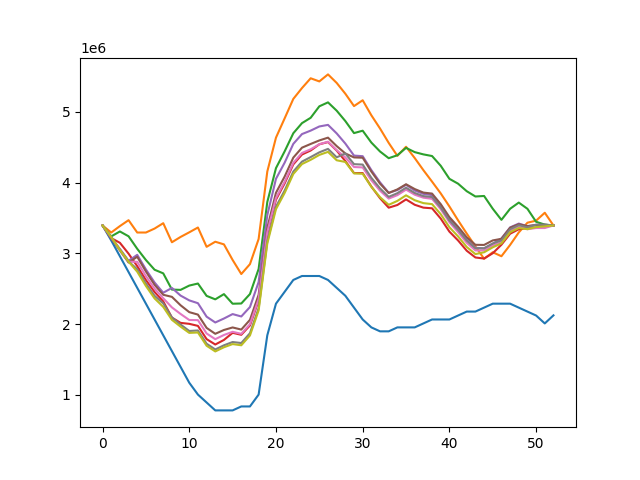

In [32]:
plt.figure()
j = 0
for i in range(len(traj)):
    plt.plot(traj[i][:,j])


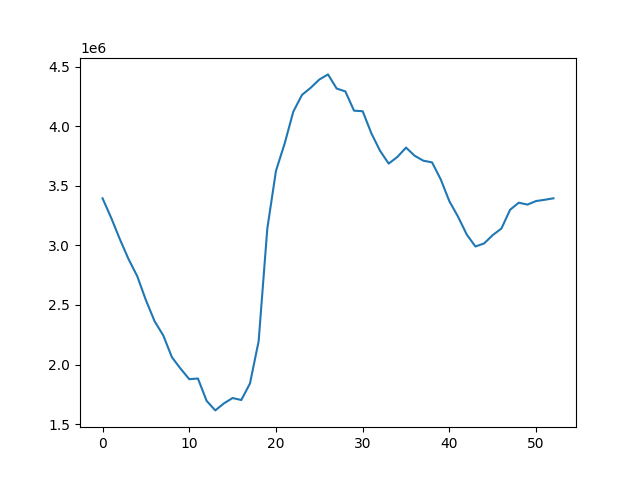

In [33]:
plt.figure()
plt.plot(traj[-1])

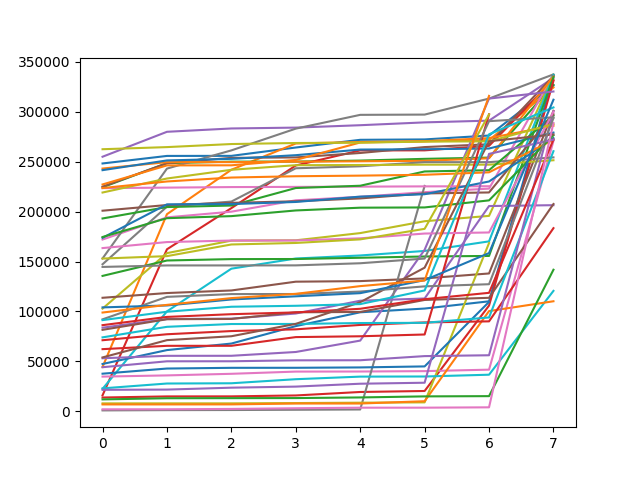

In [34]:
plt.figure()
for s in range(S):
    plt.plot(U[s][0][2:])

In [35]:
penalties = np.zeros((xNsteps, S+1))
for s in range(S+1):
    pen = interp1d([0,reservoir.Xmin[s],reservoir.Xmax[s],reservoir.capacity],[-pen_low*(reservoir.Xmin[s]),0,0,-pen_high*(reservoir.capacity-reservoir.Xmax[s])])
    for i in range(xNsteps):
        penalties[i,s] = pen(X[i])

In [37]:
s = 50
i = np.argmax([X>=reservoir.Xmin[s]])
j = np.argmin([X<=reservoir.Xmax[s]])
# i = 0
# j = xNsteps

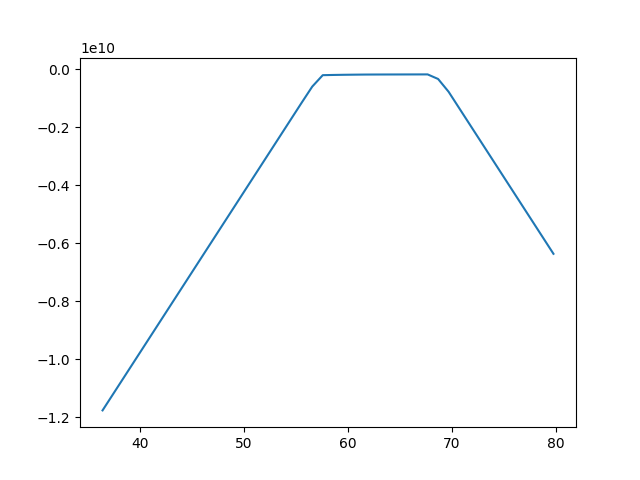

In [38]:
plt.figure()
plt.plot(X[i:j]/reservoir.capacity*100,vb[i:j,s])#-penalties[i:j,s]

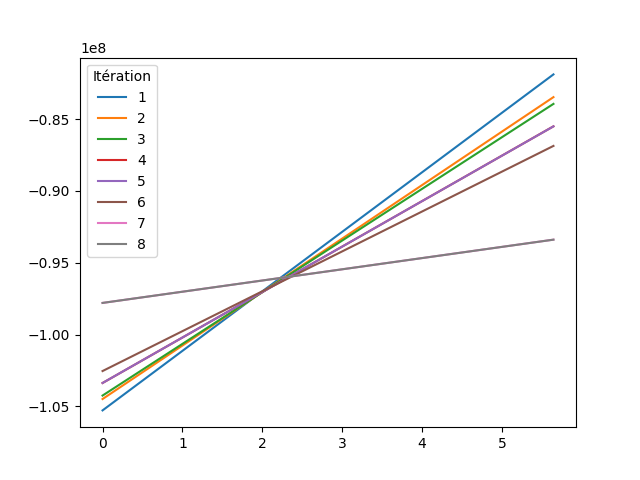

In [40]:
plt.figure()
for k in range(1,len(G[s][0])):
    g = G[s][0][k][0]*np.array(U[s][0])+G[s][0][k][1]
    plt.plot(np.array(U[s][0])/reservoir.capacity*100,g,label=f"{k}")#-penalties[i:j,s]
plt.legend(title="Itération")

In [42]:
trajectoires = np.zeros_like(np.array(controls_upper))
for i in range(len(controls_upper)):
    for s in range(S):
        for k in range(NTrain):
            if s==0:
                trajectoires[i,s,k] = reservoir.initial_level - np.array(controls_upper)[i,s,k]+reservoir.inflow[s,k]*H
            else :
                trajectoires[i,s,k] = trajectoires[i,s-1,k] - np.array(controls_upper)[i,s,k]+reservoir.inflow[s,k]*H

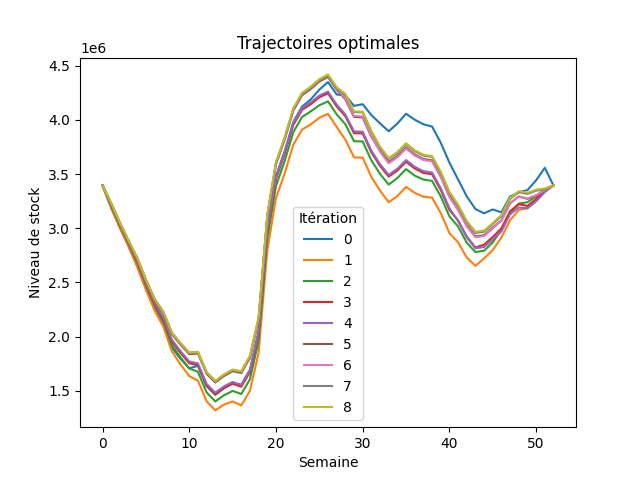

In [44]:
k = 0
plt.figure()
plt.title("Trajectoires optimales")
plt.xlabel("Semaine")
plt.ylabel("Niveau de stock")
for i in range(len(trajectoires)):
    plt.plot([reservoir.initial_level]+list(trajectoires[i,:,k]),label=f"{i}")
plt.legend(title="Itération")

# Antares Xpress

In [ ]:
f = open("Z://JulietteG//6-Etutes_Antares//log_reso_xpress.txt","r")
lines = f.readlines()

In [ ]:
len(lines)

In [ ]:
text = "".join(lines)

In [ ]:
pbs = text.split("Optimal solution found")[1:]

In [ ]:
len(pbs)

In [ ]:
times = open("Z://JulietteG//6-Etutes_Antares//ERAA_scandinavie_v82//output//20240213-1216eco-xpress//optimization//week-by-week//year_0.txt","r").readlines()

In [ ]:
itr_antares = np.zeros((2, 52, 3))

In [ ]:
for i in range(len(pbs)):
    itr_antares[i%2, i//2, 0] = int(pbs[i].split("simplex iterations")[0].strip().split(" ")[-1])
    itr_antares[i%2, i//2, 1] = int(times[i//2+1].split(" ")[1+i%2])/1000
    itr_antares[i%2, i//2, 2] = float(pbs[i].split("Final objective")[1].split(":")[1].split("\n")[0].strip())

In [ ]:
plt.figure()
for i in range(len(itr_antares)-1):
    plt.plot(itr_antares[i, :, 0], label=f"Antares")
for i in range(len(itr)):
    plt.plot(itr[i, :, :, 0], label=f"Python")
plt.legend()
plt.xlabel("Semaine")
plt.ylabel("Nombre d'itérations du simplexe")
plt.title("Première itération - année 1")

In [ ]:
plt.figure()
for i in range(len(itr_antares)-1):
    plt.plot(itr_antares[i, :, 1], label=f"Antares")
for i in range(len(itr)):
    plt.plot(itr[i, :, :, 2], label=f"Python")
plt.legend()
plt.xlabel("Semaine")
plt.ylabel("Temps de résolution")
plt.title("Première itération - année 1")

In [ ]:
plt.figure()
for i in range(len(itr_antares)-1):
    plt.plot(itr_antares[i, :, 2], label=f"Antares")
for i in range(len(itr)):
    plt.plot([-G[i+1][s][0,1]- G[i+1][s][0,0]*U[s][0][-1] for s in range(S)], label=f"Python")
plt.legend()
plt.xlabel("Semaine")
plt.ylabel("Coût de la solution")
plt.title("Première itération - année 1")